# Machine Learning on Bike Sharing Data

An exploration of ML by Eric Hilton

###Things to try:
* run models separately for weekday and weekend
* try polynomialFeatures preprocessing
* look at the hourly data:
  * heat map of median ride per hour, day vs hr
  * divide normalized heat maps from one season by another season (weekend vs working day specific)
* discussion about data we're missing - ie, do people ride bikes to baseball games - does it correlate with big conventions?

#### left off: look into scaling /normalization of the features
#### one hot encoder for days of the week
http://scikit-learn.org/stable/modules/preprocessing.html
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder

In [2]:
%matplotlib inline
import scipy
import numpy as np
import matplotlib.pyplot as plt
import datetime

The data file looks like this: 

    instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
    1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
    2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
    3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
    4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
    
So, define a convert function to handle the date, and import it with genfromtxt
The 'target' values (ie, the number of rides) are imported separately

In [3]:
convertfunc = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d")
data = np.genfromtxt("Bike-Sharing-Dataset/day.csv", skiprows=1, 
                     delimiter=",", usecols= (0,1,2,3,4,5,6,7,8,9,10,11,12), converters={1: convertfunc })
data.dtype.names = ('instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 
                    'temp', 'atemp', 'hum', 'windspeed')


In [4]:
target = np.genfromtxt("Bike-Sharing-Dataset/day.csv", skiprows=1, 
                     delimiter=",", usecols= (13,14,15), names="casual,registered,cnt")

Let's spend a bit of time just exploring the data, to see what we're dealing with - so no machine learning yet, just some regular old plots

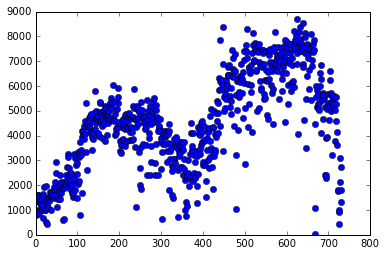

In [5]:
plt.plot(data['instant'], target['cnt'],'o')

Unsurprisingly, there is an obvious seasonal signal - it also appears that the bike share program has become more popular with time (although there could be other explanations for the generally upward trend of the data).

Now, let's see if there is a difference during weekends/holidays. Naively, I'd expect that there would be more rides on the weekends.

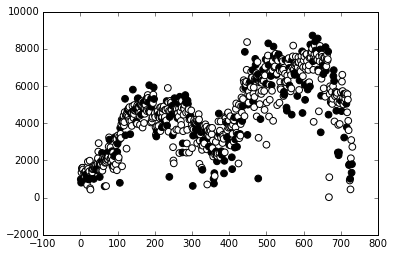

In [6]:
plt.scatter(data['instant'], target['cnt'],s=45, c=data['workingday'], cmap='gray')

By eye, there isn't a strong difference. If you look closely, though, it seems the black dots don't track the white ones completely - let's look deeper.

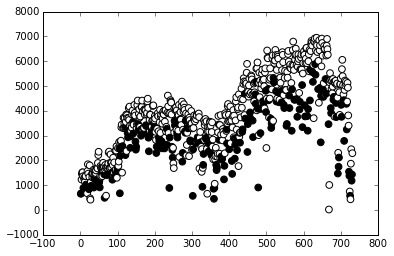

In [7]:
plt.scatter(data['instant'], target['registered'],s=45, c=data['workingday'], cmap='gray')

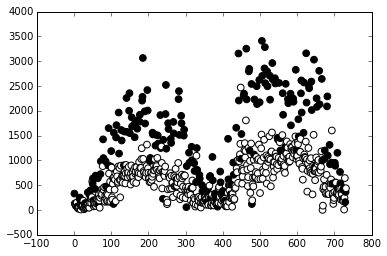

In [8]:
plt.scatter(data['instant'], target['casual'],s=45, c=data['workingday'], cmap='gray')

Even by eye there is clearly a difference between casual and registered users - a sensible hypothesis is that registered users are daily communters, whereas casual users are people who decide to go for a ride on a nice day.

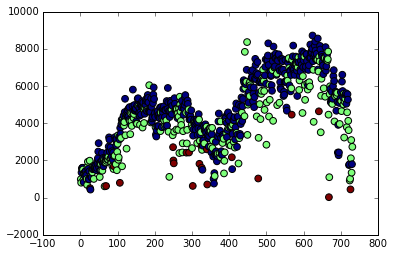

In [9]:
plt.scatter(data['instant'], target['cnt'],s=45, c=data['weathersit'],cmap='jet')

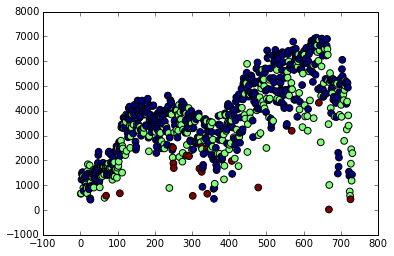

In [10]:
plt.scatter(data['instant'], target['registered'],s=45, c=data['weathersit'],cmap='jet')

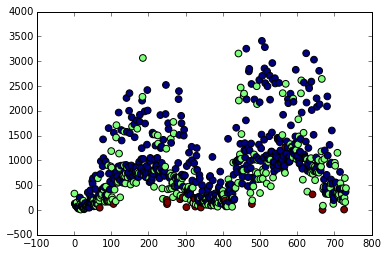

In [11]:
plt.scatter(data['instant'], target['casual'],s=45, c=data['weathersit'],cmap='jet')

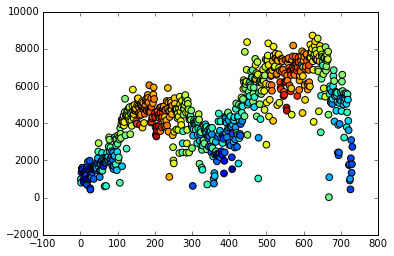

In [12]:
plt.scatter(data['instant'], target['cnt'],s=45, c=data['atemp'],cmap='jet')

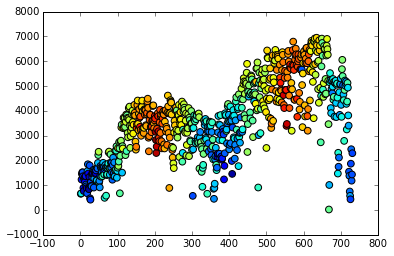

In [13]:
plt.scatter(data['instant'], target['registered'],s=45, c=data['atemp'],cmap='jet')

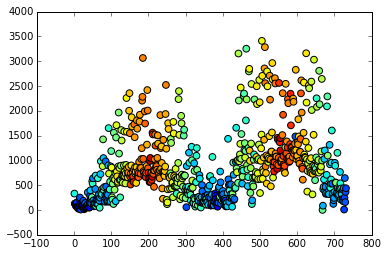

In [14]:
plt.scatter(data['instant'], target['casual'],s=45, c=data['atemp'],cmap='jet')

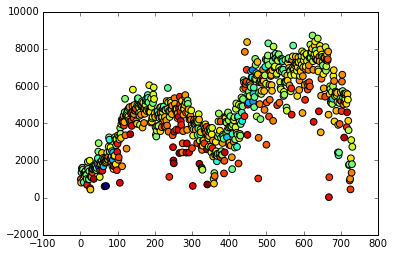

In [15]:
plt.scatter(data['instant'], target['cnt'],s=45, c=data['hum'],cmap='jet')

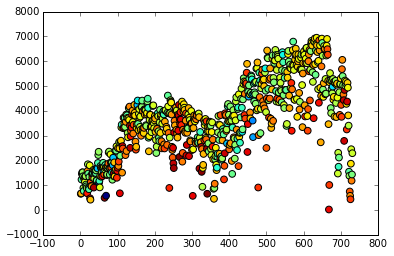

In [16]:
plt.scatter(data['instant'], target['registered'],s=45, c=data['hum'],cmap='jet')

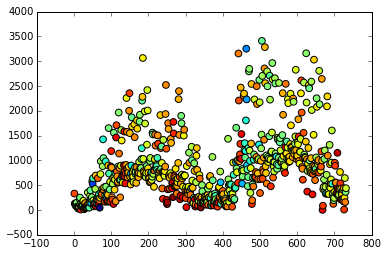

In [17]:
plt.scatter(data['instant'], target['casual'],s=45, c=data['hum'],cmap='jet')

### Now on to trying some ML techniques

for simplicity, we'll make a model just for the casual users first. 
begin with simple models - only worry about a subset of the data dimensions, don't do cross-validation.

the cheat sheet suggests we could start with lasso methods

In [18]:
X = np.zeros((data.size, 5))
for i in range(0,data.size):
    X[i,:] = np.array([data[i]['workingday'], data[i]['weathersit'], 
                       data[i]['atemp'], data[i]['hum'],data[i]['windspeed']])

In [19]:
ind = np.zeros(data.size)
for i in range(0, ind.size):
    ind[i] = data[i]['dteday'].day
a = np.where(ind <= 19)
a = a[0]
b = np.where(ind > 19)
b = b[0]
Xtrain = X[a,:]
Xtest = X[b,:]

ytrain = ((target['casual'])[a])
ytest = ((target['casual'])[b])

In [20]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.1)

lasso.fit(Xtrain,ytrain).score(Xtest,ytest)

0.55146548937584194

In [21]:
from sklearn import svm
svr = svm.SVR(kernel='linear')

svr.fit(Xtrain,ytrain).score(Xtest,ytest)

0.046045192683625058

In [22]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=0.1, l1_ratio=0.7)
enet.fit(Xtrain,ytrain).score(Xtest,ytest)

0.49472221280525019

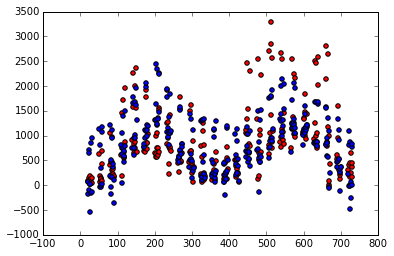

In [23]:
plt.scatter(data['instant'][b], target['casual'][b], c='red')
plt.scatter(data['instant'][b], lasso.predict(Xtest))


In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

model.fit(Xtrain,ytrain).score(Xtest,ytest)

0.64766594090604102

In [29]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.1)
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('lasso', linear_model.Lasso(alpha=0.01))])

model.fit(Xtrain,ytrain).score(Xtest,ytest)

0.71831661183138906

###Add in some more factors

[ 0.  1.]


In [33]:
X = np.zeros((data.size, 7))
for i in range(0,data.size):
    X[i,:] = np.array([data[i]['workingday'], data[i]['yr'], data[i]['weekday'], data[i]['weathersit'], 
                       data[i]['atemp'], data[i]['hum'],data[i]['windspeed']])

In [34]:
ind = np.zeros(data.size)
for i in range(0, ind.size):
    ind[i] = data[i]['dteday'].day
a = np.where(ind <= 19)
a = a[0]
b = np.where(ind > 19)
b = b[0]
Xtrain = X[a,:]
Xtest = X[b,:]

ytrain = ((target['casual'])[a])
ytest = ((target['casual'])[b])

In [38]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha = 0.0001)
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('lasso', linear_model.Lasso(alpha=0.1))])

model.fit(Xtrain,ytrain).score(Xtest,ytest)

0.78913604468583864